In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
#import keras
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import RNN, GRU, LSTM, Dense, Input, Embedding, Dropout, Activation, concatenate
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
 
    def call(self, inputs):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    """
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'num_layers': self.num_layers,
            'units': self.units,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout': self.dropout,
        })
        return config
    """

In [5]:
train_data = pd.read_csv('clean_data/train.csv')
test_data = pd.read_csv('clean_data/val.csv')
fire_data = pd.read_csv('clean_data/test.csv')

In [6]:
train_data.describe()

,Unnamed: 0,label
count,638.000000,638.000000
mean,318.500000,0.451411
std,184.319017,0.498024
min,0.000000,0.000000
25%,159.250000,0.000000
50%,318.500000,0.000000
75%,477.750000,1.000000
max,637.000000,1.000000


In [7]:
test_data.describe()

,Unnamed: 0,label
count,262.000000,262.000000
mean,130.500000,0.427481
std,75.777085,0.495660
min,0.000000,0.000000
25%,65.250000,0.000000
50%,130.500000,0.000000
75%,195.750000,1.000000
max,261.000000,1.000000


In [8]:
train_data.head()

,Unnamed: 0,news_text,label
0,410,﻿آئن سٹائن کے اپنے ہاتھ کا وہ خط متوقع کے عين...,1
1,577,نئی دہلی 15 دسمبر(ایجنسی) بین الاقوامی سطح پ...,1
2,221,نئی دہلی 5 دسمبر(ایجنسی) دہلی کے تاج ہوٹل میں...,0
3,200,میلبرن (نیوز ڈیسک) کہتے ہیں کہ وزن ایک بار ب...,0
4,486,نیوزی لینڈ 10 مئی (ایجنسی) امریکہ میں ماہرین ...,1


In [9]:
test_data.head()

,Unnamed: 0,news_text,label
0,189,﻿لڑکپن بے شک زندگی کا سب سے مختلف حصہ ہے کیون...,1
1,256,﻿ناسا کا ’بی ایف آر‘ راکٹ اور ہوائی جہاز انسا...,1
2,246,بیجنگ چینی حکومت نے امریکا سے تیل کی خریدار...,1
3,181,﻿کمان سے نکلا تنکا یا زبان سے نکلا جملہ کی وا...,1
4,201,لندن سائنسدانوں کا خیال ہے کہ صحتمند انسانوں...,1


In [10]:
train_data.isnull().any()

Unnamed: 0    False
news_text     False
label         False
dtype: bool

In [11]:
test_data.isnull().any()

Unnamed: 0    False
news_text     False
label         False
dtype: bool

In [12]:
# Furhter actions on any columns is not required, because no columns has any missing data.

In [13]:

y = train_data["label"].values

y_val = test_data["label"].values

In [14]:
train_sentences = train_data["news_text"].fillna("fillna").str.lower()
test_sentences = test_data["news_text"].fillna("fillna").str.lower()
fire_sentences = fire_data["news_text"].fillna("fillna").str.lower()

In [15]:
max_features = 10000
max_len = 250
embed_size = 300

In [16]:
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(list(train_sentences))

In [17]:
tokenized_train_sentences = tokenizer.texts_to_sequences(train_sentences)
tokenized_test_sentences = tokenizer.texts_to_sequences(test_sentences)
tokenized_fire_sentences = tokenizer.texts_to_sequences(fire_sentences)

In [18]:
len(train_sentences[94].split(" "))

264

In [19]:
#tokenized_train_sentences[1]

In [20]:
train_sentences[5]

' لندن (ویب ڈیسک) آج کل کے دور میں ہر کوئی بالخصوص خواتین خوبصورت اور رنگ گورا کرنے سمیت کم عمر نظر آنے کی دوڑ میں لگی ہوئی ہیں جن افراد کا رنگ گورا گندمی ہوتا ہے انہیں گورا ہونے اور جو گورے ہیں انہیں گندمی ہونے کا شوق ہے اس دور میں لوگ بہت سی ایسی مہنگی کریمیں اور ماسک وغیرہ استعمال کرتے ہیں جن سے انہیں وقتی طور پر تو اپنے متعلقہ نتائج مل جاتے ہیں لیکن بعدازاں نقصان اٹھانا پڑتا ہے بہت سی لڑکیاں اسی کوشش میں اپنے چہرے کی پلاسٹک سرجری بھی کروا لیتی ہیں جس کے سنگین نتائج سے وہ آشنا ہوتی ہیں حال ہی میں رپورٹ کے مطابق ایک لڑکی نے پرکشش نظر آنے کی کوشش میں اپنی شکل کا حُلیہ خراب کر لیا ہے  لیکن اب پچھتائے کیا ہوت جب چڑیاں چگ گئیں کھیت دی مرر کے مطابق اس ماہر کا نام مکتیہے جو ایک نامیاتی سکن کیئر کمپنی کی مالک بھی ہے اس نے بتایا ہے کہ  گھریلو ٹوٹکوں سے رنگ گورا کرنا انتہائی آسان اور سستا طریقہ ہے جیسا کہ کریم میں گندم کا آٹا چاول کا آٹا سوڈا لیموں اوپٹن اور ہلدی کے استعمال سے آپ اپنا رنگ گورا کر سکتے ہیں اگر چند دن اس پر عمل کیا جائے تو آپ اپنی عمر سے کئی سال چھوٹے لگنے لگیں گے مکتی کا مزید 

In [21]:
#tokenized_train_sentences[5]

In [22]:
train_padding = pad_sequences(tokenized_train_sentences, max_len)
test_padding = pad_sequences(tokenized_test_sentences, max_len)
fire_padding = pad_sequences(tokenized_fire_sentences, max_len)

In [23]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = 10000
inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
#saved_model = "weights_base.best.hdf5"
#saved_model = "transformer_test.hdf5"
#checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
#callbacks_list = [checkpoint, early]

In [26]:
batch_sz = 25
epoch = 25
#model.fit(train_padding, y, batch_size=batch_sz, epochs=epoch, validation_split=0.1, callbacks=callbacks_list)
#callbacks=callbacks_list
history = model.fit(train_padding, y, batch_size=batch_sz, epochs=epoch, validation_data=(test_padding, y_val))

Epoch 1/25
26/26 [==============================] - 2s 77ms/step - loss: 1.0998 - accuracy: 0.5157 - val_loss: 0.6983 - val_accuracy: 0.5191
Epoch 2/25
26/26 [==============================] - 2s 65ms/step - loss: 0.7260 - accuracy: 0.5596 - val_loss: 0.6987 - val_accuracy: 0.5687
Epoch 3/25
26/26 [==============================] - 2s 66ms/step - loss: 0.6150 - accuracy: 0.6771 - val_loss: 0.6854 - val_accuracy: 0.5458
Epoch 4/25
26/26 [==============================] - 2s 67ms/step - loss: 0.5519 - accuracy: 0.7132 - val_loss: 0.6833 - val_accuracy: 0.5725
Epoch 5/25
26/26 [==============================] - 2s 64ms/step - loss: 0.4563 - accuracy: 0.7994 - val_loss: 0.6848 - val_accuracy: 0.5611
Epoch 6/25
26/26 [==============================] - 2s 66ms/step - loss: 0.3691 - accuracy: 0.8464 - val_loss: 0.7149 - val_accuracy: 0.5305
Epoch 7/25
26/26 [==============================] - 2s 70ms/step - loss: 0.2829 - accuracy: 0.8966 - val_loss: 0.6959 - val_accuracy: 0.5725
Epoch 8/25
26

In [27]:
#from tensorflow.keras.models import load_model

#weights = load_model('transformer_test.hdf5').get_weights()
#model.set_weights(weights)
test_values = model.predict([fire_padding], batch_size=25, verbose=1)


16/16 [==============================] - 0s 22ms/step


In [28]:
test_labels = [1 if x >=0.5 else 0 for x in test_values]
print(test_labels)

[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 

In [29]:
import csv

inputfile = open("clean_data/test.csv","r")
csv_reader = csv.reader(inputfile)
data_fire = list(csv_reader)

csv_m1 = open("submissions/model4.csv", "w+")
writer = csv.writer(csv_m1, delimiter=",")

writer.writerow(["File No", "Real/Fake"])
for i in range(len(test_labels)):
    
    if test_labels[i] == 0:
        writer.writerow([i+1, "R"])
    elif test_labels[i] == 1:
        writer.writerow([i+1, "F"])
    else:
        #pass
        print("error: ", i)
        
#outfile.close()
csv_m1.close()

In [30]:
#from sklearn.metrics import classification_report
#target_names = ['real', 'fake']
#print(classification_report(y_val, test_values.round(), target_names=target_names))

[0.5190839767456055, 0.5687022805213928, 0.5458015203475952, 0.572519063949585, 0.5610687136650085, 0.5305343270301819, 0.572519063949585, 0.5687022805213928, 0.5992366671562195, 0.6030534505844116, 0.6221374273300171, 0.6183205842971802, 0.6335877776145935, 0.614503800868988, 0.6297709941864014, 0.6106870174407959, 0.6412213444709778, 0.652671754360199, 0.6717557311058044, 0.6603053212165833, 0.6679389476776123, 0.6564885377883911, 0.6488549709320068, 0.6641221642494202, 0.6832060813903809] [0.5156739950180054, 0.5595611333847046, 0.6771159768104553, 0.7131661176681519, 0.7993730306625366, 0.846394956111908, 0.8965517282485962, 0.9294670820236206, 0.9498432874679565, 0.9733542203903198, 0.9702194333076477, 0.9905956387519836, 0.9874607920646667, 0.982758641242981, 0.9921630024909973, 0.9858934283256531, 0.9952977895736694, 0.9937304258346558, 0.9890282154083252, 0.9937304258346558, 0.9905956387519836, 0.9952977895736694, 0.9968652129173279, 0.9937304258346558, 0.9937304258346558]


<Figure size 432x288 with 0 Axes>

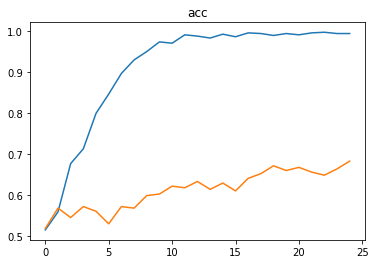

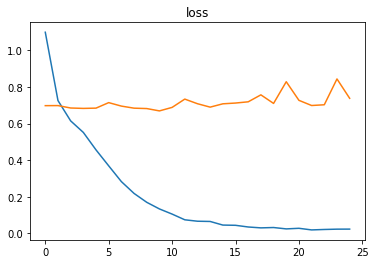

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt 

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

print(val_acc,acc)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title("acc")
plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title("loss")
plt.figure()
